In [12]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import make_grid

# Loading Dataset

In [15]:

with open("/content/hw5_tr7.pkl","rb") as f:
    tr = pickle.load(f)
with open("/content/hw5_te7.pkl","rb") as f:
    te = pickle.load(f)

tr = np.array(tr, dtype=np.float32)
te = np.array(te, dtype=np.float32)

if tr.max() > 1:
    tr = tr / 255.
    te = te / 255.

tr = tr[:, None, :, :]
te = te[:, None, :, :]

class MyDS(Dataset):
    def __init__(self, arr):
        self.arr = arr
    def __len__(self):
        return len(self.arr)
    def __getitem__(self, i):
        return torch.tensor(self.arr[i], dtype=torch.float32)

train_loader = DataLoader(MyDS(tr), batch_size=128, shuffle=True)
test_loader  = DataLoader(MyDS(te), batch_size=128, shuffle=False)

# Model encoder and decoder

In [16]:
LATENT = 10

#Encoder
enc_conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
enc_conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
enc_conv3 = nn.Conv2d(32, 64, 3, padding=1)
fc_mu     = nn.Linear(64*7*7, LATENT)
fc_logvar = nn.Linear(64*7*7, LATENT)

#Decoder
fc_dec = nn.Linear(LATENT, 64*7*7)
dec_deconv1 = nn.ConvTranspose2d(64, 32, 3, padding=1)
dec_deconv2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
dec_deconv3 = nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1)

params = (
    list(enc_conv1.parameters()) +
    list(enc_conv2.parameters()) +
    list(enc_conv3.parameters()) +
    list(fc_mu.parameters()) +
    list(fc_logvar.parameters()) +
    list(fc_dec.parameters()) +
    list(dec_deconv1.parameters()) +
    list(dec_deconv2.parameters()) +
    list(dec_deconv3.parameters()))

#optimizer
optimizer = torch.optim.Adam(params, lr=1e-3)

In [17]:

train_losses = []
val_losses = []

EPOCHS = 500

for epoch in range(EPOCHS):
    running_loss = 0
    for batch in train_loader:
        x = batch
        h = F.relu(enc_conv1(x))
        h = F.relu(enc_conv2(h))
        h = F.relu(enc_conv3(h))
        h = h.view(h.size(0), -1)

        mu = fc_mu(h)
        logvar = fc_logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std


        h2 = fc_dec(z)
        h2 = h2.view(-1, 64, 7, 7)
        h2 = F.relu(dec_deconv1(h2))
        h2 = F.relu(dec_deconv2(h2))
        xrec = torch.sigmoid(dec_deconv3(h2))


        recon = F.binary_cross_entropy(xrec, x, reduction="sum")
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(tr))


    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            x = batch
            h = F.relu(enc_conv1(x))
            h = F.relu(enc_conv2(h))
            h = F.relu(enc_conv3(h))
            h = h.view(h.size(0), -1)
            mu = fc_mu(h)
            logvar = fc_logvar(h)
            z = mu
            h2 = fc_dec(z)
            h2 = h2.view(-1, 64, 7, 7)
            h2 = F.relu(dec_deconv1(h2))
            h2 = F.relu(dec_deconv2(h2))
            xrec = torch.sigmoid(dec_deconv3(h2))
            recon = F.binary_cross_entropy(xrec, x, reduction="sum")
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            val_loss += (recon + kl).item()
    val_losses.append(val_loss / len(te))
    print(f"Epoch {epoch+1:02d} | Train={train_losses[-1]:.6f} | Val={val_losses[-1]:.6f}")


Epoch 01 | Train=297.816681 | Val=200.718631
Epoch 02 | Train=197.257924 | Val=175.349382
Epoch 03 | Train=166.260917 | Val=149.572029
Epoch 04 | Train=146.451610 | Val=130.161945
Epoch 05 | Train=129.963977 | Val=117.063769
Epoch 06 | Train=119.622260 | Val=110.212534
Epoch 07 | Train=113.421865 | Val=105.174194
Epoch 08 | Train=110.232100 | Val=103.366865
Epoch 09 | Train=108.260334 | Val=101.357972
Epoch 10 | Train=106.491099 | Val=100.441367
Epoch 11 | Train=105.337552 | Val=99.178842
Epoch 12 | Train=104.237635 | Val=98.814141
Epoch 13 | Train=103.262687 | Val=98.394627
Epoch 14 | Train=102.742988 | Val=96.953993
Epoch 15 | Train=101.786742 | Val=96.326564
Epoch 16 | Train=101.281906 | Val=95.881732
Epoch 17 | Train=100.860314 | Val=95.501821
Epoch 18 | Train=100.186603 | Val=95.660676
Epoch 19 | Train=100.033221 | Val=95.882711
Epoch 20 | Train=99.694091 | Val=94.806397
Epoch 21 | Train=99.296191 | Val=94.465156
Epoch 22 | Train=98.832094 | Val=94.229561
Epoch 23 | Train=98.65051

# Training and validation loss curve

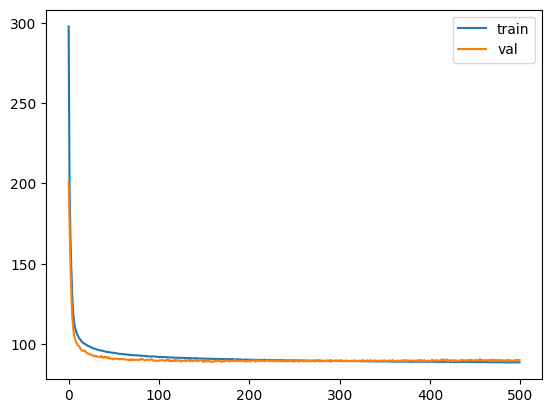

In [18]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

In [19]:
mus = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i > 8: break
        x = batch

        h = F.relu(enc_conv1(x))
        h = F.relu(enc_conv2(h))
        h = F.relu(enc_conv3(h))
        h = h.view(h.size(0), -1)

        mu = fc_mu(h)
        mus.append(mu.cpu().numpy())

fixed_context = np.mean(np.concatenate(mus), axis=0)
print("Fixed context =", fixed_context)

Fixed context = [-0.04075076  0.05416592  0.07981332 -0.09569687  0.05056199 -0.02349485
 -0.04144031 -0.0991869  -0.04138528 -0.03742284]


# Latent dimention analysis

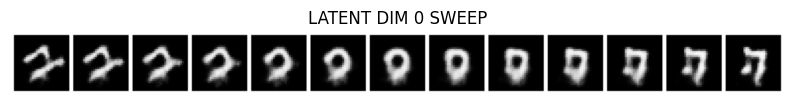

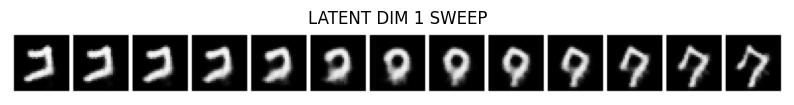

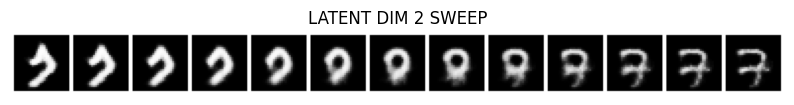

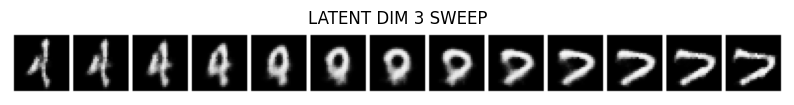

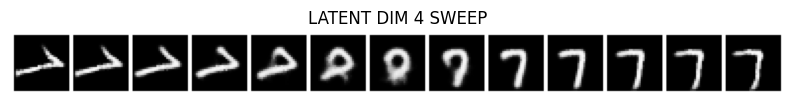

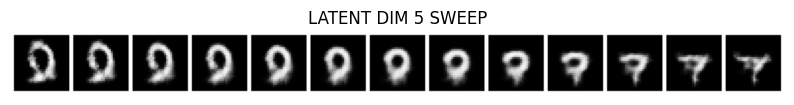

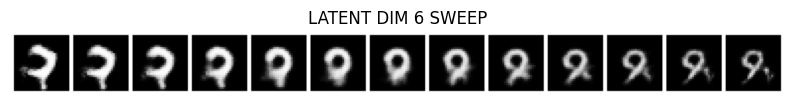

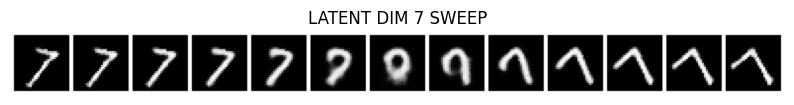

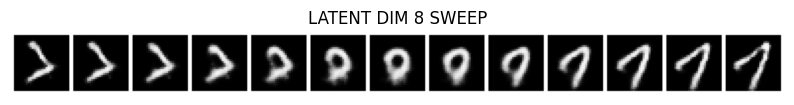

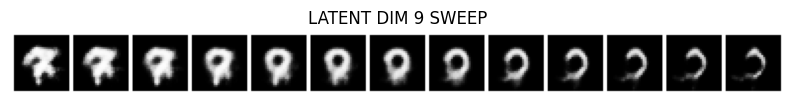

In [20]:
n_steps = 13
values = np.linspace(-4, 4, n_steps)

for dim in range(LATENT):

    Z = np.tile(fixed_context, (n_steps,1))
    Z[:, dim] = values

    Z_tensor = torch.tensor(Z, dtype=torch.float32)

    with torch.no_grad():
        h2 = fc_dec(Z_tensor)
        h2 = h2.view(-1, 64, 7, 7)
        h2 = F.relu(dec_deconv1(h2))
        h2 = F.relu(dec_deconv2(h2))
        imgs = torch.sigmoid(dec_deconv3(h2))

    grid = make_grid(imgs.cpu(), nrow=n_steps, pad_value=1)
    plt.figure(figsize=(10,3))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.title(f"LATENT DIM {dim} SWEEP")
    plt.axis('off')
    plt.show()

# The hidden feature looks like zero or black hole lol!!

# Random Generated Image

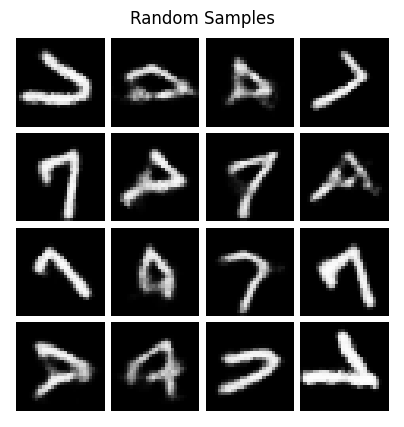

In [21]:
Z_random = torch.randn(16, LATENT)

with torch.no_grad():
    h2 = fc_dec(Z_random)
    h2 = h2.view(-1, 64, 7, 7)
    h2 = F.relu(dec_deconv1(h2))
    h2 = F.relu(dec_deconv2(h2))
    imgs = torch.sigmoid(dec_deconv3(h2))

grid = make_grid(imgs.cpu(), nrow=4, pad_value=1)
plt.figure(figsize=(5,5))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
plt.title("Random Samples")
plt.axis('off')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files

!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/CCopy of DLS_HW4_2.ipynb"
files.download("/content/drive/MyDrive/Colab Notebooks/Copy of DLS_HW4_2.html")